# Лабораторная 4. Метод k-ближайших соседей
## Ярослав Лукьянчук 367361
## Датасет про про вино
---
1. Загрузка и предобработка данных

In [68]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [69]:
data = pd.read_csv('./WineDataset.csv')

In [70]:
data.head()

,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Wine
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,1
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,1
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,1
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malic Acid                    178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity of ash             178 non-null    float64
 4   Magnesium                     178 non-null    float64
 5   Total phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  OD280/OD315 of diluted wines  178 non-null    float64
 12  Proline                       178 non-null    float64
 13  Wine 

In [72]:
features = data.drop(columns=['Wine'])
scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
scaled_data['Wine'] = data['Wine'].values

<function matplotlib.pyplot.show(close=None, block=None)>

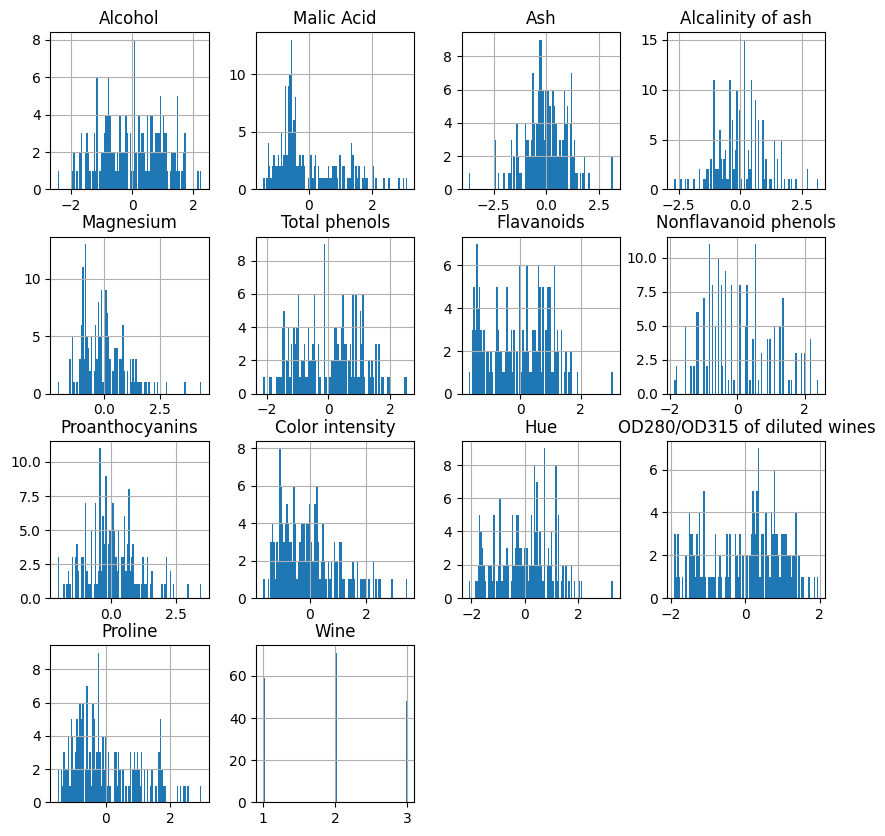

In [73]:
scaled_data.hist(bins=100, figsize=(10,10))
plt.show

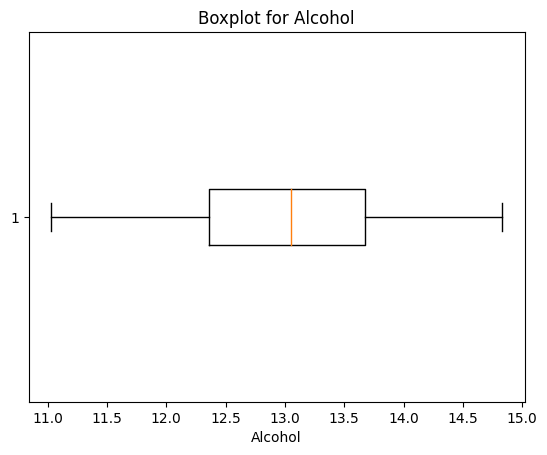

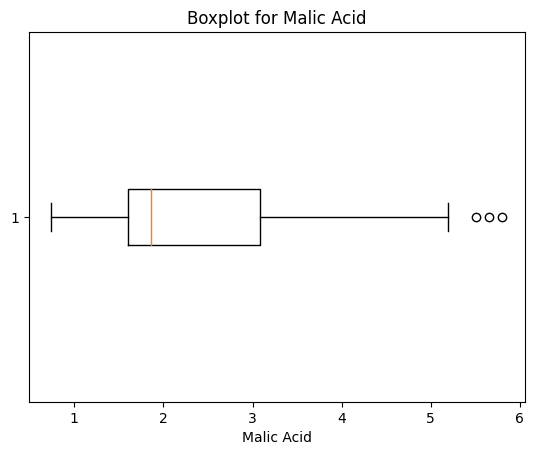

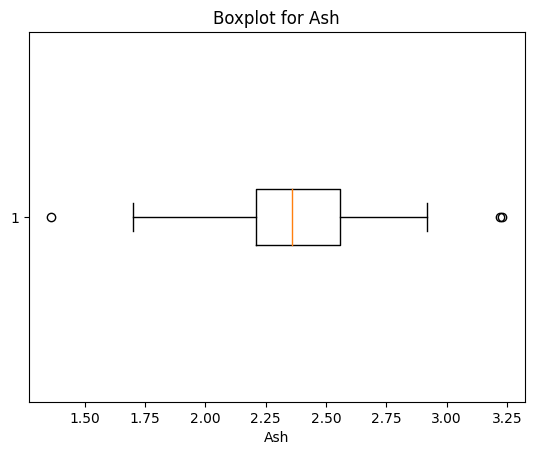

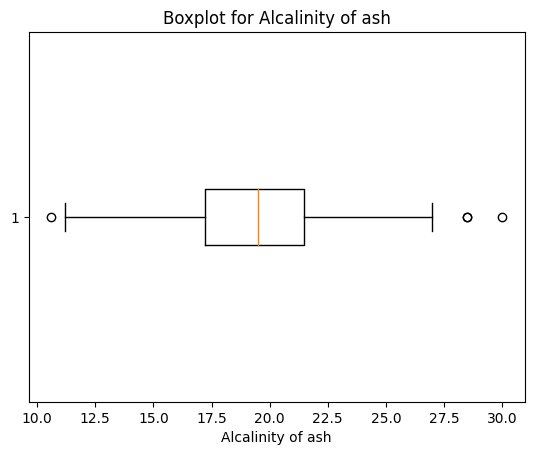

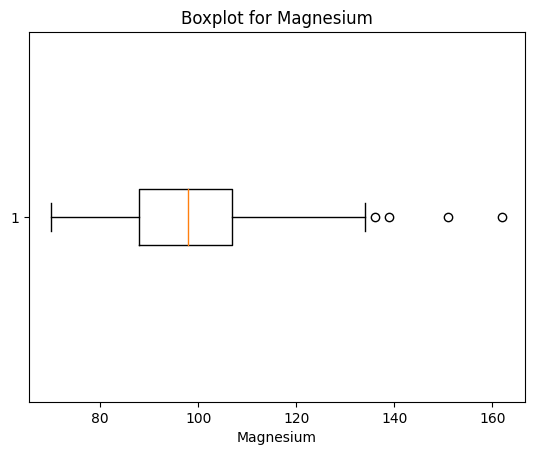

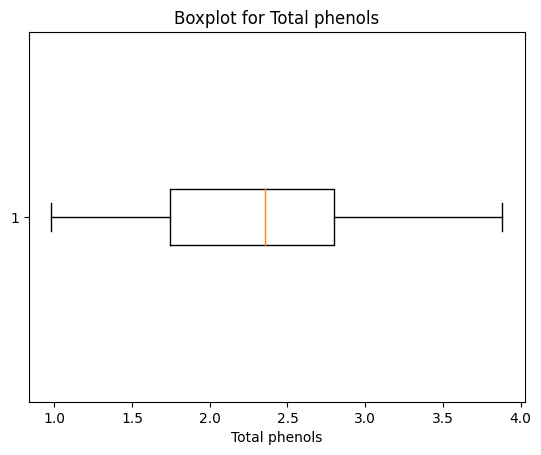

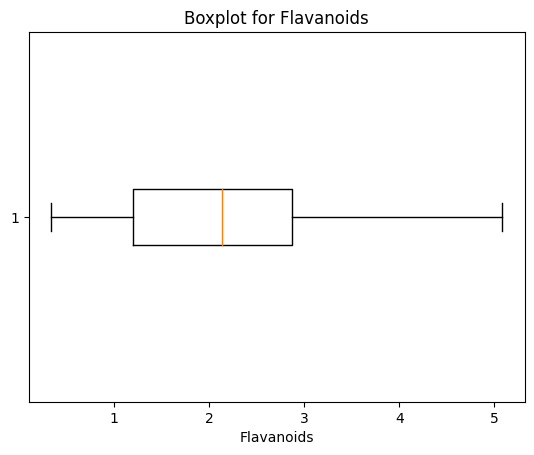

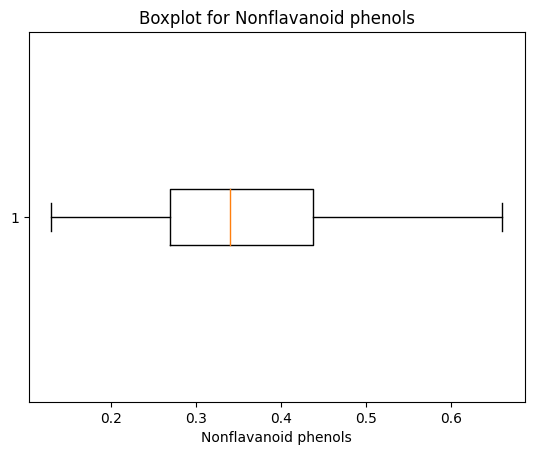

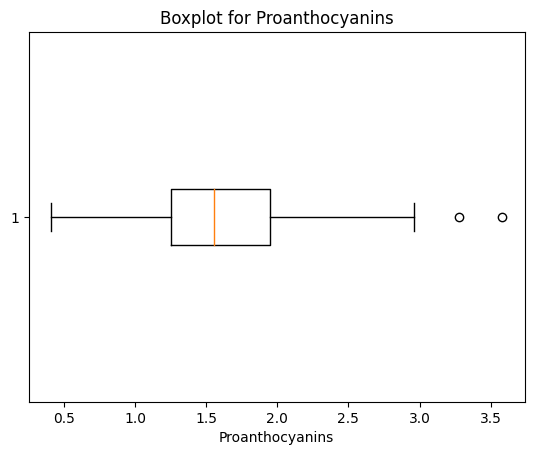

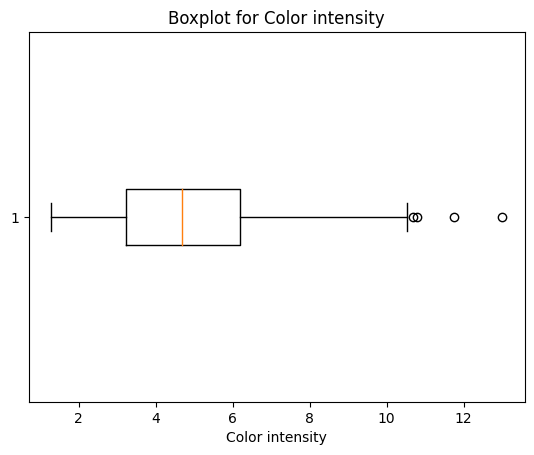

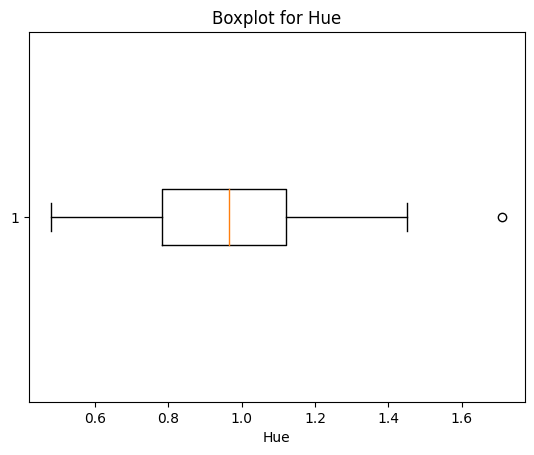

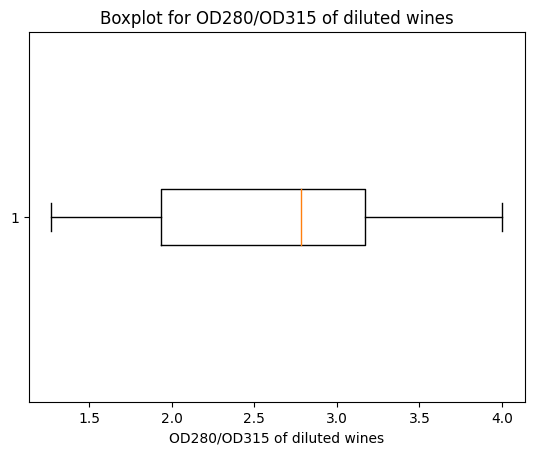

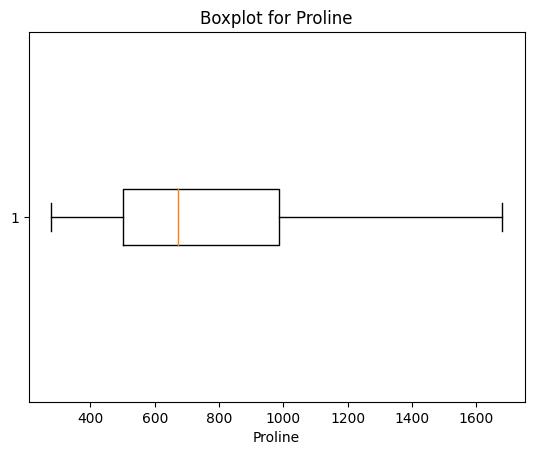

In [85]:
for column in data.drop(columns=['Wine']).columns:
    plt.boxplot(data[column], vert=False)
    plt.xlabel(column)
    plt.title(f'Boxplot for {column}')
    plt.show()

<Axes: >

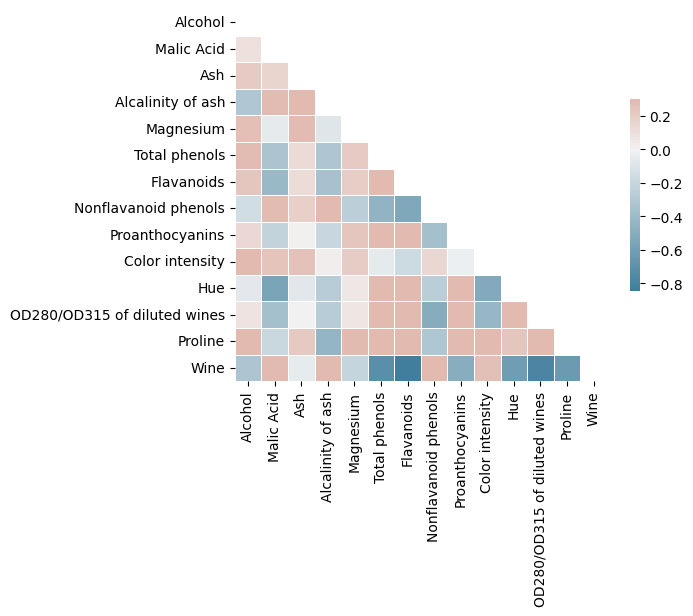

In [74]:
corr = scaled_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(6, 5))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

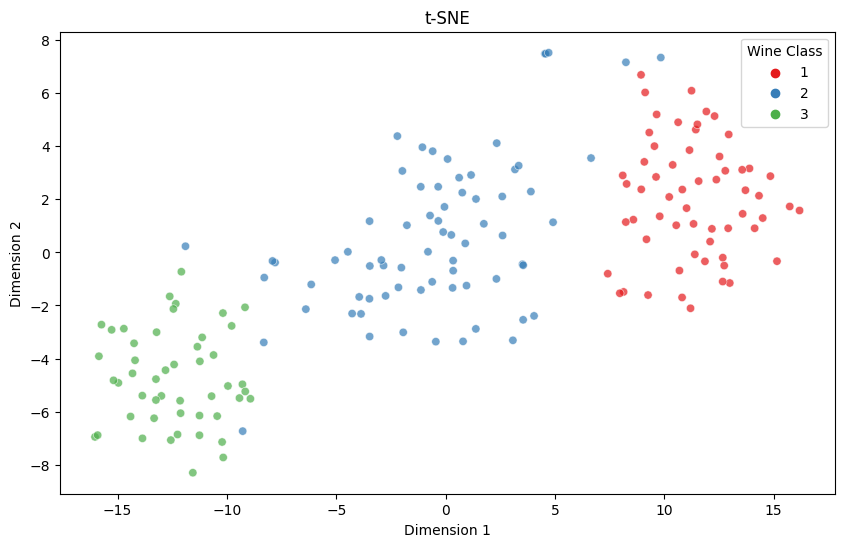

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_data.drop('Wine',axis='columns'))

tsne_df = pd.DataFrame(data=tsne_results, columns=['Dim1', 'Dim2'])
tsne_df['Wine'] = data['Wine']  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dim1', y='Dim2', hue='Wine', data=tsne_df, palette='Set1', alpha=0.7)
plt.title('t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Wine Class')
plt.show()

## 2. Метод k ближайших соседей

1. **Обучение модели**:
   - Сохраняем обучающие данные:
     - Признаки: $\mathbf{X}_{\text{train}}$
     - Целевые значения: $\mathbf{y}_{\text{train}}$

2. **Расчет расстояний**:
   - Евклидово расстояние между точками $\mathbf{x}$ и $\mathbf{x}_{\text{train}}$:
   $$
   d(\mathbf{x}, \mathbf{x}_{\text{train}}) = \|\mathbf{x} - \mathbf{x}_{\text{train}}\|_2
   $$

3. **Поиск $k$ ближайших соседей**:
   - Индексы ближайших соседей:
   $$
   \text{k\_nearest\_labels} = \text{argsort}(d(\mathbf{x}, \mathbf{X}_{\text{train}}))[:k]
   $$

4. **Голосование**:
   - Предсказанная метка класса:
   $$
   \hat{y} = \text{argmax}(\text{bincount}(\text{nearest\_labels}))
   $$

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix

In [77]:
class MyKNN:
    def __init__(self, k=3, random_features=None):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.random_features = random_features

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X_train = X if isinstance(X, np.ndarray) else X.to_numpy()
        self.y_train = y if isinstance(y, np.ndarray) else y.to_numpy()

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = X if isinstance(X, np.ndarray) else X.to_numpy()
        predictions = np.zeros(X.shape[0])

        n_features = X.shape[1]

        for i in range(X.shape[0]):
            if self.random_features is not None and self.random_features < n_features:
                selected_features = np.random.choice(n_features, self.random_features, replace=False)
                X_i_selected = X[i, selected_features].reshape(1, -1)
                X_train_selected = self.X_train[:, selected_features]
            else:
                X_i_selected = X[i].reshape(1, -1)
                X_train_selected = self.X_train

            distances = distance.cdist(X_i_selected, X_train_selected, 'euclidean')[0]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            predictions[i] = np.bincount(k_nearest_labels).argmax()

        return predictions

0.9661016949152542


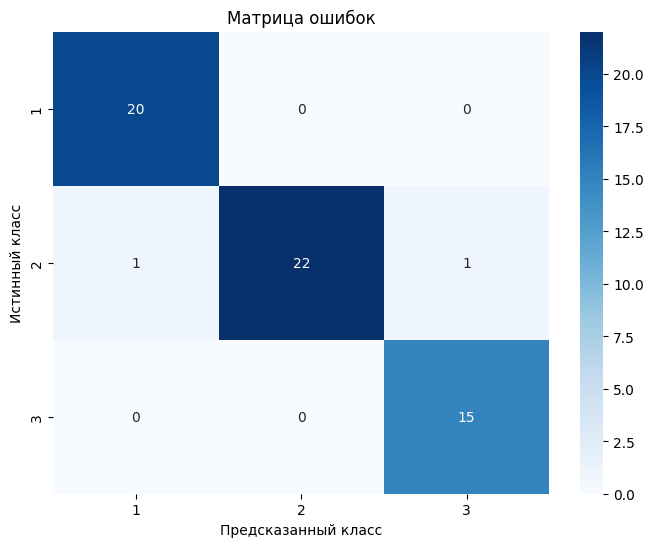

In [78]:
model = MyKNN()
X, y = scaled_data.drop('Wine',axis='columns'), scaled_data['Wine']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

model.fit(X_train, y_train)
score = accuracy_score(y_test, model.predict(X_test))
print(score)

cm = confusion_matrix(y_test, model.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

In [79]:
for k in range(1, 11):
    model = MyKNN(k=k)
    model.fit(X_train, y_train)
    score = accuracy_score(y_test, model.predict(X_test))
    print(f'Accuracy for k={k}: {score}')

Accuracy for k=1: 0.9661016949152542
Accuracy for k=2: 0.9491525423728814
Accuracy for k=3: 0.9661016949152542
Accuracy for k=4: 0.9661016949152542
Accuracy for k=5: 0.9661016949152542
Accuracy for k=6: 0.9491525423728814
Accuracy for k=7: 0.9661016949152542
Accuracy for k=8: 0.9491525423728814
Accuracy for k=9: 0.9491525423728814
Accuracy for k=10: 0.9322033898305084


0.6779661016949152


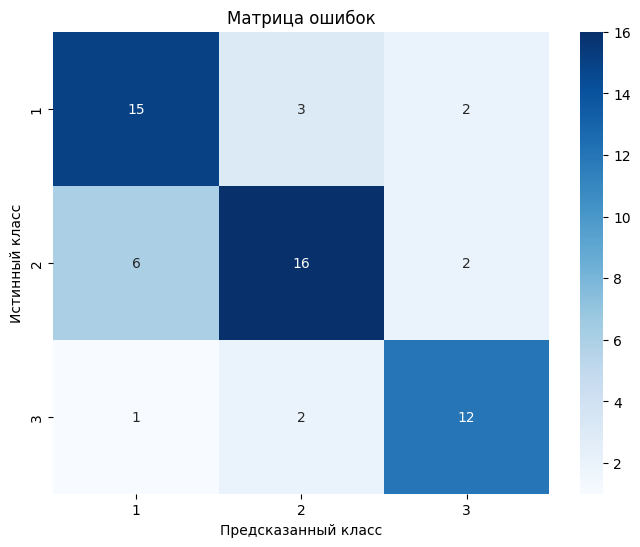

In [80]:
model = MyKNN(random_features=2)
X, y = scaled_data.drop('Wine',axis='columns'), scaled_data['Wine']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

model.fit(X_train, y_train)
score = accuracy_score(y_test, model.predict(X_test))
print(score)

cm = confusion_matrix(y_test, model.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

In [87]:
for k in range(1, 5):
    for feature in range(1,5):
        model = MyKNN(k=k,random_features=feature)
        model.fit(X_train, y_train)
        score = accuracy_score(y_test, model.predict(X_test))
        print(f'Accuracy for k={k}, random_features={feature}: {score}')

Accuracy for k=1, random_features=1: 0.5932203389830508
Accuracy for k=1, random_features=2: 0.6610169491525424
Accuracy for k=1, random_features=3: 0.8135593220338984
Accuracy for k=1, random_features=4: 0.7796610169491526
Accuracy for k=2, random_features=1: 0.5932203389830508
Accuracy for k=2, random_features=2: 0.7796610169491526
Accuracy for k=2, random_features=3: 0.8135593220338984
Accuracy for k=2, random_features=4: 0.8135593220338984
Accuracy for k=3, random_features=1: 0.6271186440677966
Accuracy for k=3, random_features=2: 0.6779661016949152
Accuracy for k=3, random_features=3: 0.7457627118644068
Accuracy for k=3, random_features=4: 0.8813559322033898
Accuracy for k=4, random_features=1: 0.6271186440677966
Accuracy for k=4, random_features=2: 0.7627118644067796
Accuracy for k=4, random_features=3: 0.7627118644067796
Accuracy for k=4, random_features=4: 0.9661016949152542
